In [1]:
"This notebook is for calculating single cell RNA velocity with Dynamo."

'This notebook is for calculating single cell RNA velocity with Dynamo.'

In [2]:
import dynamo as dyn
import numpy as np
from scipy import stats,signal
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.neighbors import KernelDensity
import networkx as nx
import os
from numpy.random import randint

/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sirin/anaconda3/envs/sc_env/lib/pyt

In [3]:
result_path='result/'
# gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)
dim_n=10
adata=dyn.read('data/'+'DG_bin_ppt.h5ad')
t_list=['Granule', 'ImmGranule1', 'ImmGranule2', 'Nbl1', 'Nbl2', 'RadialGlia', 'nIPC']

/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.


/tmp/ipykernel_1944/1361459412.py:1: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata,keep_filtered_genes=False,keep_filtered_cells=True)


|-----> ensure all labeling data properly collapased
|-----? dynamo detects your data is size factor normalized and/or log transformed. If this is not right, plese set `normalized = False.
|-----> filtering cells...
|-----> 3127 cells passed basic filters.
|-----> filtering gene...
|-----> 352 genes passed basic filters.
|-----> calculating size factor...
|-----? only 352 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
|-----> selecting genes in layer: X, sort method: SVR...
|-----> Discarding genes that failed the filtering...
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [7.5052s]
|-----> [Cell Cycle Scores Estimation] completed 

estimating gamma: 100%|██████████| 678/678 [00:07<00:00, 91.58it/s] 


|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0015s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering ClusterName by stack threshold when stacking color because it is not a numeric type


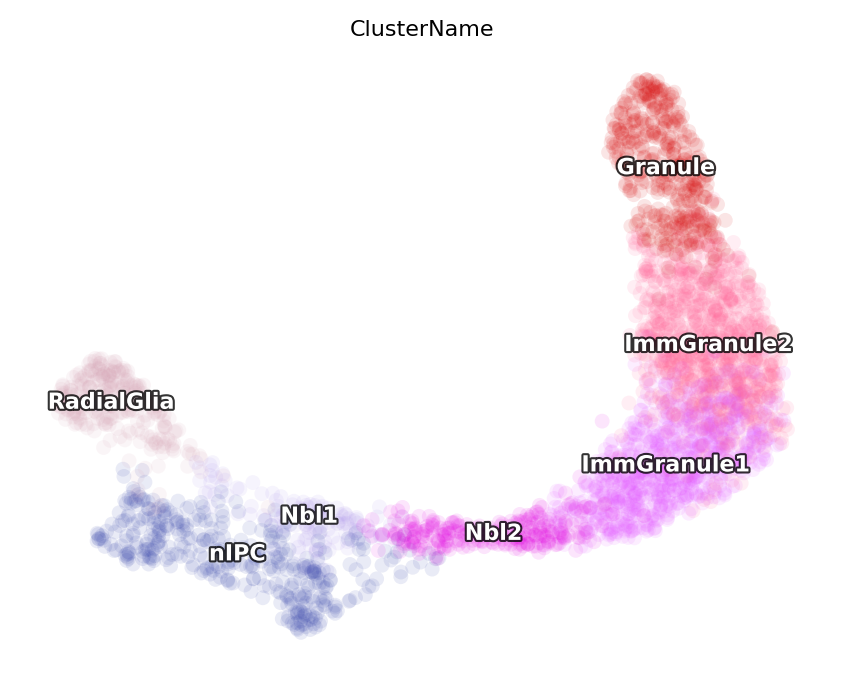

In [4]:
dyn.pp.recipe_monocle(adata,keep_filtered_genes=False,keep_filtered_cells=True)

dyn.tl.dynamics(adata,assumption_mRNA='auto')
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color='ClusterName',pointsize=0.1)

In [5]:
dyn.tl.cell_velocities(adata, method='fp',basis='pca',  correct_density=False)#ekey='M_s',vkey='velocity_S',

|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3646s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 3139 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'palantir_pseudotime', 'palantir_entropy', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_

|-----------> plotting with basis key=X_pca
|-----------> skip filtering ClusterName by stack threshold when stacking color because it is not a numeric type


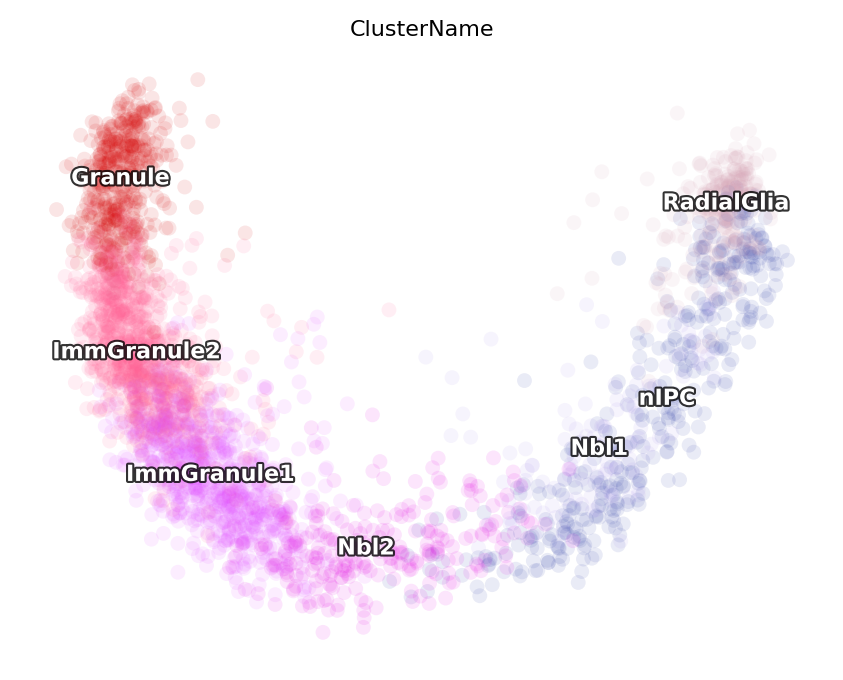

In [6]:
dyn.pl.pca(adata, color='ClusterName',pointsize=0.1)

In [7]:
adata.write('data/'+'DG_bin_ppt_fp.h5ad')